# 1. Library Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

# 2. Dataset

In [2]:
df_reviews = pd.read_csv('Data/model_reviews.csv')

df_reviews.head()

,reviews,sentiment
0,talk stone cold classic genre feels fresh thri...,Positive
1,group youngsters discover taking part small ri...,Positive
2,danny michael philippou truly made something s...,Positive
3,watched talk early part regals mystery monday ...,Positive
4,premise initially drew although different simi...,Positive


In [3]:
df_reviews.sentiment.value_counts()

sentiment
Positive    7665
Negative    5772
Neutral     1043
Name: count, dtype: int64

## 2.1. Balancing classes and pre-processing

**Resample explanations:** 
- replace: If True, upsampling will be done with replacement, meaning that the same instances can be sampled multiple times. This is commonly used in upsampling to balance the classes.

- n_samples: The total number of samples after resampling. In the context of balancing classes, you usually want to set n_samples to the number of samples from the majority class, so that the minority class is increased to reach this number.

In [4]:
# Class balancing
df_positive = df_reviews[df_reviews['sentiment'] == 'Positive']
df_negative = df_reviews[df_reviews['sentiment'] == 'Negative']
df_neutral = df_reviews[df_reviews['sentiment'] == 'Neutral']

# Upsample das classes 'Negative' e 'Neutral' to balance
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_positive), random_state=42)
df_neutral_upsampled = resample(df_neutral, replace=True, n_samples=len(df_positive), random_state=42)

# Combine balanced df
df_balanced = pd.concat([df_positive, df_negative_upsampled, df_neutral_upsampled])

# 3. Naïve-Bayes

In [5]:
# Data pre-processing
X = df_balanced['reviews']
y = df_balanced['sentiment']

In [6]:
y.value_counts()

sentiment
Positive    7665
Negative    7665
Neutral     7665
Name: count, dtype: int64

## 3.1. Vectorization

Enables a text convertion so it can be represented as numeric values

In [7]:
# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

## 3.2 Spliting for training and test

- Diving the data in train (80%) and test (20%) to follow the pareto principle 
- Traning a multinomial NB model

In [8]:
# Divisão dos dados em conjuntos de treinamento e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação e treinamento do modelo Naive Bayes Multinomial
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [9]:
df_balanced.shape[0] * 0.2

4599.0

## 3.3. Results

In [10]:
# Realização de previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliação do desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.81
Relatório de Classificação:
              precision    recall  f1-score   support

    Negative       0.80      0.79      0.80      1530
     Neutral       0.88      0.87      0.87      1540
    Positive       0.76      0.78      0.77      1529

    accuracy                           0.81      4599
   macro avg       0.81      0.81      0.81      4599
weighted avg       0.81      0.81      0.81      4599



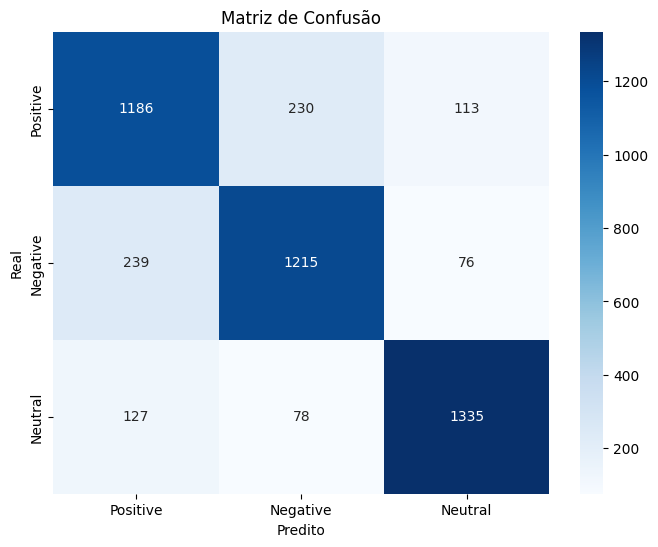

In [11]:
# Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

# Definir as classes
classes = ['Positive', 'Negative', 'Neutral']

# Plotar a matriz de confusão
plot_confusion_matrix(y_test, y_pred, classes)

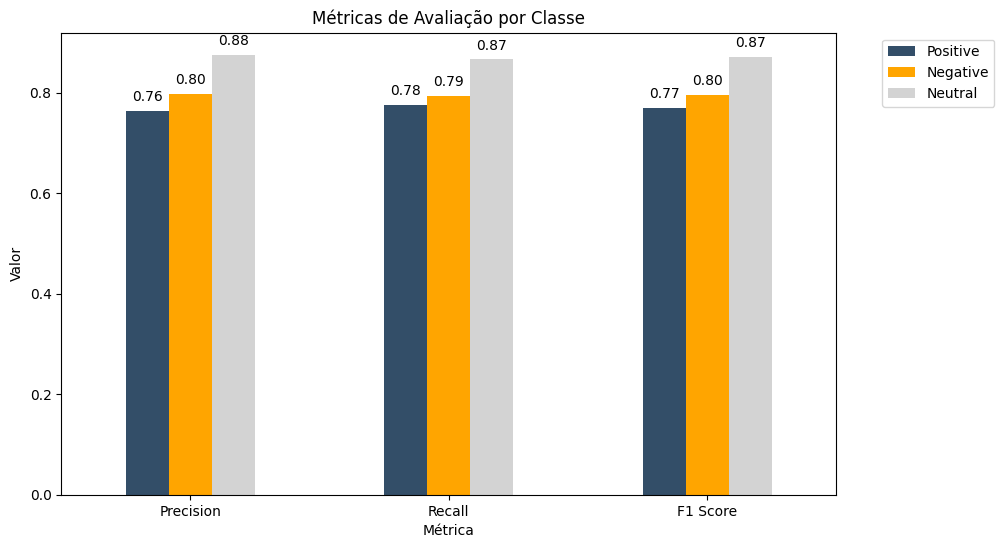

In [12]:
# Ploting metricas
def plot_metrics(y_true, y_pred, classes):
    precision = precision_score(y_true, y_pred, average=None, labels=classes)
    recall = recall_score(y_true, y_pred, average=None, labels=classes)
    f1 = f1_score(y_true, y_pred, average=None, labels=classes)

    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=classes)

    # Transpõe o DataFrame para facilitar a plotagem
    metrics_df = metrics_df.T

    # Definir cores para cada classe
    colors = {'Positive': '#334E68', 'Negative': 'orange', 'Neutral': 'lightgrey'}

    # Plotar o gráfico de barras
    ax = metrics_df.plot(kind='bar', figsize=(10, 6), color=[colors.get(c, 'grey') for c in classes], rot=0)

    # Adicionar os valores acima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title('Métricas de Avaliação por Classe')
    plt.ylabel('Valor')
    plt.xlabel('Métrica')
    
    # Posiciona a legenda fora da área do gráfico
    plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


# Plotar métricas
plot_metrics(y_test, y_pred, classes)

# 4. Neural Network (BERT)

In [41]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df_balanced, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Tokenize and format the input data
def tokenize_data(data, max_len=64):
    input_ids = []
    attention_masks = []

    for sentence in data['reviews']:
        encoding = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    labels = torch.tensor(data['sentiment'].astype('category').cat.codes.values, dtype=torch.long)

    return TensorDataset(input_ids, attention_masks, labels)

In [43]:
# Tokenize the training and testing data
train_dataset = tokenize_data(train_data)
test_dataset = tokenize_data(test_data)

# Split the training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for each set
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pyth

In [44]:
# Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 3

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        input_ids, attention_masks, labels = batch
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|████████████████████████████████| 460/460 [11:34<00:00,  1.51s/it]


Average training loss: 0.8397328002945237


Epoch 2: 100%|████████████████████████████████| 460/460 [11:34<00:00,  1.51s/it]


Average training loss: 0.4874479105291159


Epoch 3: 100%|████████████████████████████████| 460/460 [11:28<00:00,  1.50s/it]

Average training loss: 0.24486063823265874


In [45]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc='Validation'):
        input_ids, attention_masks, labels = batch
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)

        val_preds.extend(predicted_labels.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Evaluate on validation set
print('Validation Report:')
print(classification_report(val_labels, val_preds))
print(f'Accuracy: {accuracy_score(val_labels, val_preds)}')

Validation: 100%|█████████████████████████████| 115/115 [00:43<00:00,  2.65it/s]

Validation Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1239
           1       0.93      0.97      0.95      1213
           2       0.85      0.88      0.86      1228

    accuracy                           0.89      3680
   macro avg       0.89      0.89      0.89      3680
weighted avg       0.89      0.89      0.89      3680



In [46]:
# Test loop
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        input_ids, attention_masks, labels = batch
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)

        test_preds.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# Evaluate on test set
print('Test Report:')
print(classification_report(test_labels, test_preds))
print(f'Accuracy: {accuracy_score(test_labels, test_preds)}')

Testing: 100%|████████████████████████████████| 144/144 [00:54<00:00,  2.66it/s]

Test Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1530
           1       0.92      0.95      0.94      1540
           2       0.85      0.86      0.85      1529

    accuracy                           0.89      4599
   macro avg       0.89      0.89      0.89      4599
weighted avg       0.89      0.89      0.89      4599

Accuracy: 0.8875842574472711


In [56]:
# Mapping numerical labels to categorical classes
class_mapping = {0: 'Positive', 1: 'Negative', 2: 'Neutral'}

# Convert numerical labels to categorical labels
test_labels_cat = [class_mapping[label] for label in test_labels]
test_preds_cat = [class_mapping[label] for label in test_preds]

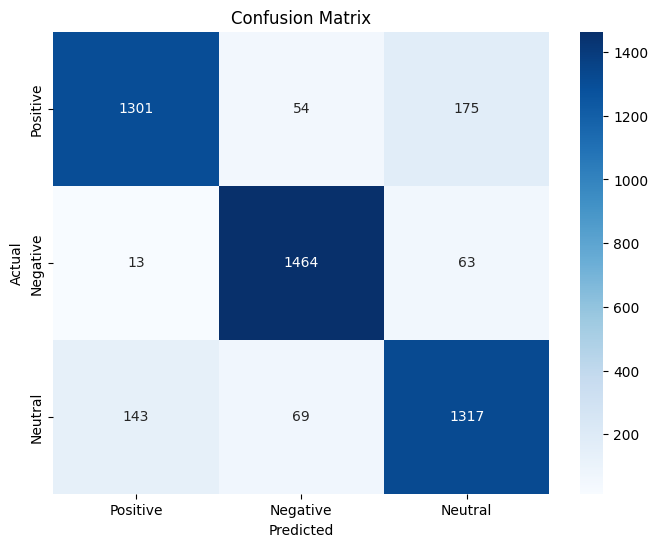

In [61]:
# Confusion Matrix Function
def plot_confusion_matrix_BERT(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Define the classes
classes = ['Positive', 'Negative', 'Neutral']

# Plot the confusion matrix
plot_confusion_matrix_BERT(test_labels_cat, test_preds_cat, classes=classes)

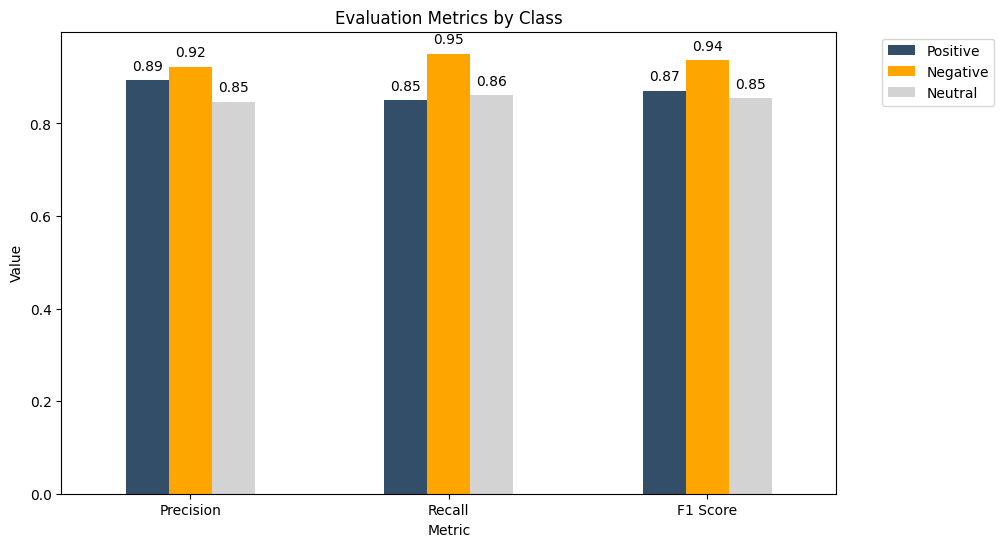

In [69]:
def plot_metrics_BERT(y_true, y_pred, classes):
    unique_labels = sorted(set(y_true + y_pred))
    precision = precision_score(y_true, y_pred, average=None, labels=classes)
    recall = recall_score(y_true, y_pred, average=None, labels=classes)
    f1 = f1_score(y_true, y_pred, average=None, labels=classes)

    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=classes)

    # Transpose the DataFrame for easier plotting
    metrics_df = metrics_df.T

    # Define colors for each class
    colors = {'Positive': '#334E68', 'Negative': 'orange', 'Neutral': 'lightgrey'}

    # Plot the bar chart
    ax = metrics_df.plot(kind='bar', figsize=(10, 6), color=[colors.get(c, 'grey') for c in classes], rot=0)

    # Add values above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title('Evaluation Metrics by Class')
    plt.ylabel('Value')
    plt.xlabel('Metric')
    
    # Position the legend outside the plot area
    plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    
# Define the classes
classes = ['Positive', 'Negative', 'Neutral']

# Plot metrics
plot_metrics_BERT(test_labels_cat, test_preds_cat, classes)